In [91]:
# Imports
import numpy  as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from joblib import dump
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble      import RandomForestRegressor
from src.tools             import ml_error
from src.tools             import timeSeries_CV
from scipy.stats import randint
warnings.filterwarnings( 'ignore' )
from src.tools import jupyter_settings

In [92]:
jupyter_settings()

In [ ]:
X = pd.read_csv('data/X.csv')
y  = pd.read_csv('data/y.csv')

### 8. Hyperparameter Fine tuning

In [ ]:
# Definir o modelo a ser otimizado (Regressão com Random Forest)
model = RandomForestRegressor()

# Definir os hiperparâmetros e intervalos para otimização
# Primeiro Ciclo, Adotar como default a maioria dos parametros e testar numero de estimadores e Max_features
# Para evitar crash decidi reduzir o max_depth para 40, pois a média de max_depth do modelo default era de 53
param_dist = {
    'n_estimators': randint(100,250),
    'criterion':['squared_erro', 'absolute_error', 'friedman_mse', 'poisson'],
    
    
}

# Criar objeto TimeSeriesSplit para validação cruzada
tscv = TimeSeriesSplit(n_splits=5)

# Criar o objeto RandomizedSearchCV
search = RandomizedSearchCV(model, param_distributions =param_dist, cv=tscv, n_iter = 5, scoring='neg_mean_squared_error',random_state= 42, verbose = 10)


# Realizar a busca aleatória
search.fit(X, y)

# Avaliar o melhor modelo encontrado
best_model = search.best_estimator_

In [ ]:
# performance
rf_result_tuned = timeSeries_CV(X, y, model_name='Random Forest Regressor Tuned', model=best_model, kfold=5)
rf_result_tuned

In [ ]:
best_model.get_params()

### 8.2. Final Model

In [3]:
#dataset

X_train  = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

X_train = X_train.drop(['date', 'sales'], axis= 1)
X_test = X_test.drop(['date', 'sales'], axis= 1)

In [ ]:
param_tuned = {'bootstrap': True,
                'ccp_alpha': 0.0,
                'criterion': 'poisson',
                'max_depth': None,
                'max_features': 1.0,
                'max_leaf_nodes': None,
                'max_samples': None,
                'min_impurity_decrease': 0.0,
                'min_samples_leaf': 1,
                'min_samples_split': 2,
                'min_weight_fraction_leaf': 0.0,
                'n_estimators': 120,
                'n_jobs': None,
                'oob_score': False,
                'random_state': None,
                'verbose': 0,
                'warm_start': False}

In [4]:
# Model

model_rf_tuned = RandomForestRegressor(criterion= 'poisson',
                                        n_estimators=120,
                                        verbose= 1,
                                        n_jobs= 4
                                        ).fit(X_train, y_train)



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed: 13.8min finished


In [5]:
# prediction
yhat_rf_tuned = model_rf_tuned.predict(X_test)

#performance

rf_result_tuned = ml_error('Random Forest regression Tuned', np.expm1(y_test), np.expm1(yhat_rf_tuned))
rf_result_tuned

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:  1.0min finished


,Model Name,MAE,MAPE,RMSE
0,Random Forest regression Tuned,666.945423,0.098721,996.554457


In [6]:
# Salvar o modelo

dump(model_rf_tuned, 'model_rf_tuned.joblib')

['model_rf_tuned.joblib']

In [27]:
def mean_percentage_erro(y, yhat):
        return np.mean((y - yhat)/y)

In [23]:
# Verificar se o modelo esta Superestimando ou Subestimando

mpe = mean_percentage_erro(np.expm1(list(y_test['sales'])), np.expm1(yhat_rf_tuned))
mpe

-0.021554458777328464

## 9. TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [40]:
df9 = pd.read_csv('data/X_test.csv')

#Rescale

df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_rf_tuned)

### 9.1 Bussines Performance

In [83]:
# sum of predictions
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import sklearn.metrics            

df91 = df9[['store', 'predictions']].groupby( 'store' ).agg(['sum','mean']).reset_index()
df91.columns = df91.columns.get_level_values(1)
df91.rename(columns={'':'store','sum' : 'total_prediction','mean': 'mean_prediction'},inplace= True)

#MAE and MAPE
df9_aux1 = df9[['store', 'sales','predictions']].groupby( 'store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns= {0:'MAE'})
df9_aux2 = df9[['store', 'sales','predictions']].groupby( 'store').apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index().rename( columns={0:'MAPE'})

#merge

df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )



# Scenarios

df92['worst_scenario_total'] = df92['total_prediction'] - df92['MAE']*42
df92['best_scenario_total'] = df92['total_prediction'] + df92['MAE']*42

df92['worst_scenario_mean'] = df92['mean_prediction'] - df92['MAE']
df92['best_scenario_mean'] = df92['mean_prediction'] + df92['MAE']

df92['absolute_error'] = df92['MAE']*42
#order columns

# Visão total
df93 = df92[['store', 'total_prediction', 'worst_scenario_total', 'best_scenario_total', 'absolute_error' ,'MAPE']]

#visão diaria

df94 = df92[['store','mean_prediction', 'worst_scenario_mean', 'best_scenario_mean','MAE', 'MAPE']]


In [84]:
df93

,store,total_prediction,worst_scenario_total,best_scenario_total,absolute_error,MAPE
0,1,164164.686164,152726.527098,175602.845231,11438.159067,0.063313
1,2,180725.900884,164058.378740,197393.423029,16667.522145,0.076174
2,3,264790.760322,238309.702857,291271.817786,26481.057465,0.090382
3,4,352933.550538,321163.537139,384703.563937,31770.013399,0.072898
4,5,171528.354103,156634.369063,186422.339143,14893.985040,0.083988
...,...,...,...,...,...,...
1110,1111,181306.296708,154789.621071,207822.972346,26516.675638,0.139385
1111,1112,341968.537888,304197.792778,379739.282999,37770.745111,0.115873
1112,1113,248148.890078,222003.973700,274293.806457,26144.916378,0.102412
1113,1114,788652.115796,702822.426195,874481.805397,85829.689601,0.086796


In [85]:
df94

,store,mean_prediction,worst_scenario_mean,best_scenario_mean,MAE,MAPE
0,1,4436.883410,4164.546289,4709.220530,272.337121,0.063313
1,2,4884.483808,4487.638042,5281.329573,396.845765,0.076174
2,3,7156.507036,6526.005668,7787.008404,630.501368,0.090382
3,4,9538.744609,8782.315719,10295.173500,756.428890,0.072898
4,5,4635.901462,4281.282771,4990.520154,354.618691,0.083988
...,...,...,...,...,...,...
1110,1111,4900.170181,4268.820761,5531.519601,631.349420,0.139385
1111,1112,9242.392916,8343.089461,10141.696371,899.303455,0.115873
1112,1113,6706.726759,6084.228750,7329.224768,622.498009,0.102412
1113,1114,21314.922049,19271.358010,23358.486087,2043.564038,0.086796


<Axes: xlabel='store', ylabel='MAPE'>

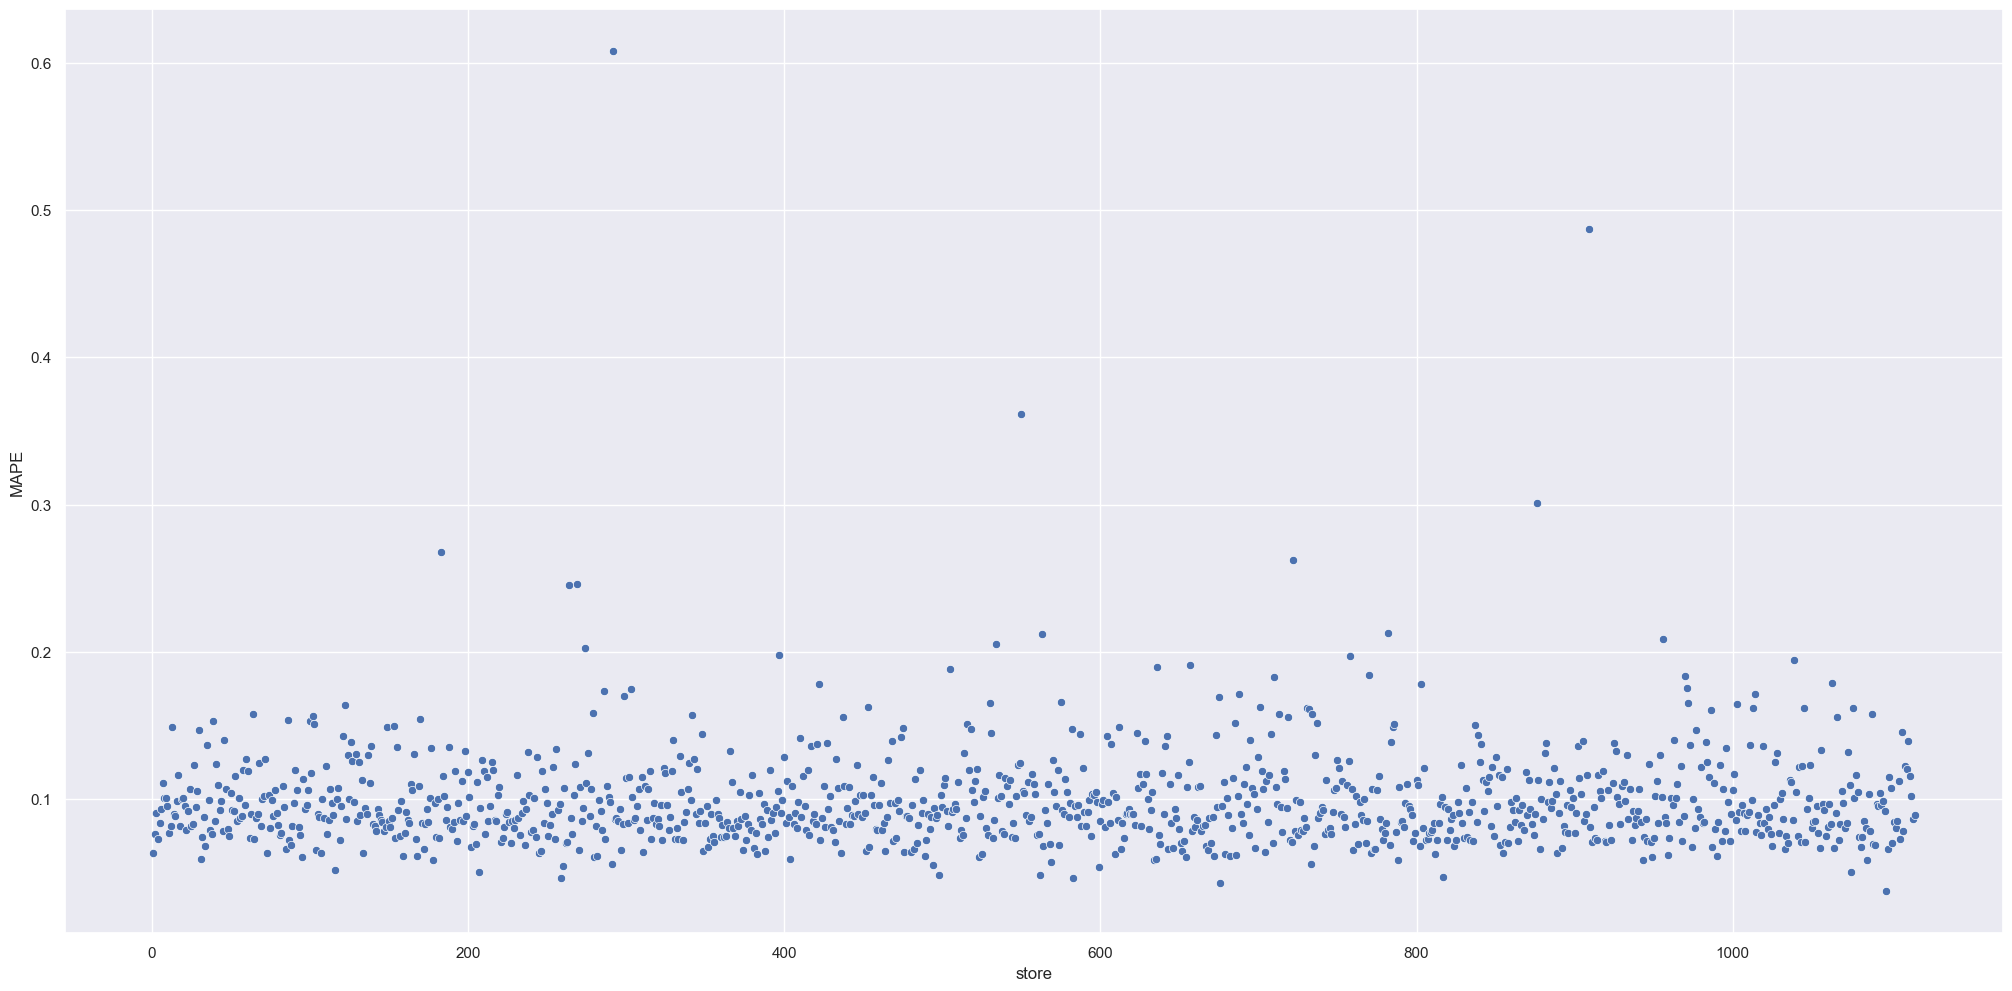

In [101]:
sns.scatterplot( x='store', y='MAPE', data=df92)


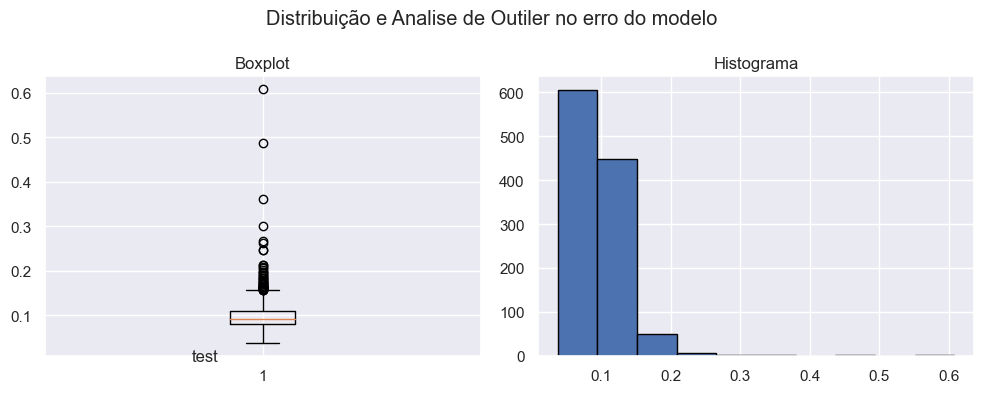

In [115]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

#Titulo
fig.suptitle('Distribuição e Analise de Outiler no erro do modelo')

fig.text(s = 'test', y = 0.1, x = 0.2)
# Boxplot
axes[0].boxplot(df92['MAPE'])
axes[0].set_title('Boxplot')
# Histograma
axes[1].hist(df92['MAPE'], bins=10, edgecolor='black')
axes[1].set_title('Histograma')

plt.tight_layout()
plt.show()

### 9.2 Total Performance

In [109]:
df95 = df92[['total_prediction', 'worst_scenario_total', 'best_scenario_total']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index': 'Scenario', 0: 'Values'})
df95['Values'] = df95['Values'].map( 'R${:,.2f}'.format )
df95

,Scenario,Values
0,total_prediction,"R$289,766,398.55"
1,worst_scenario_total,"R$258,365,744.30"
2,best_scenario_total,"R$321,167,052.81"


### 9.3 Machine Learning Performance

<Axes: xlabel='predictions', ylabel='error'>

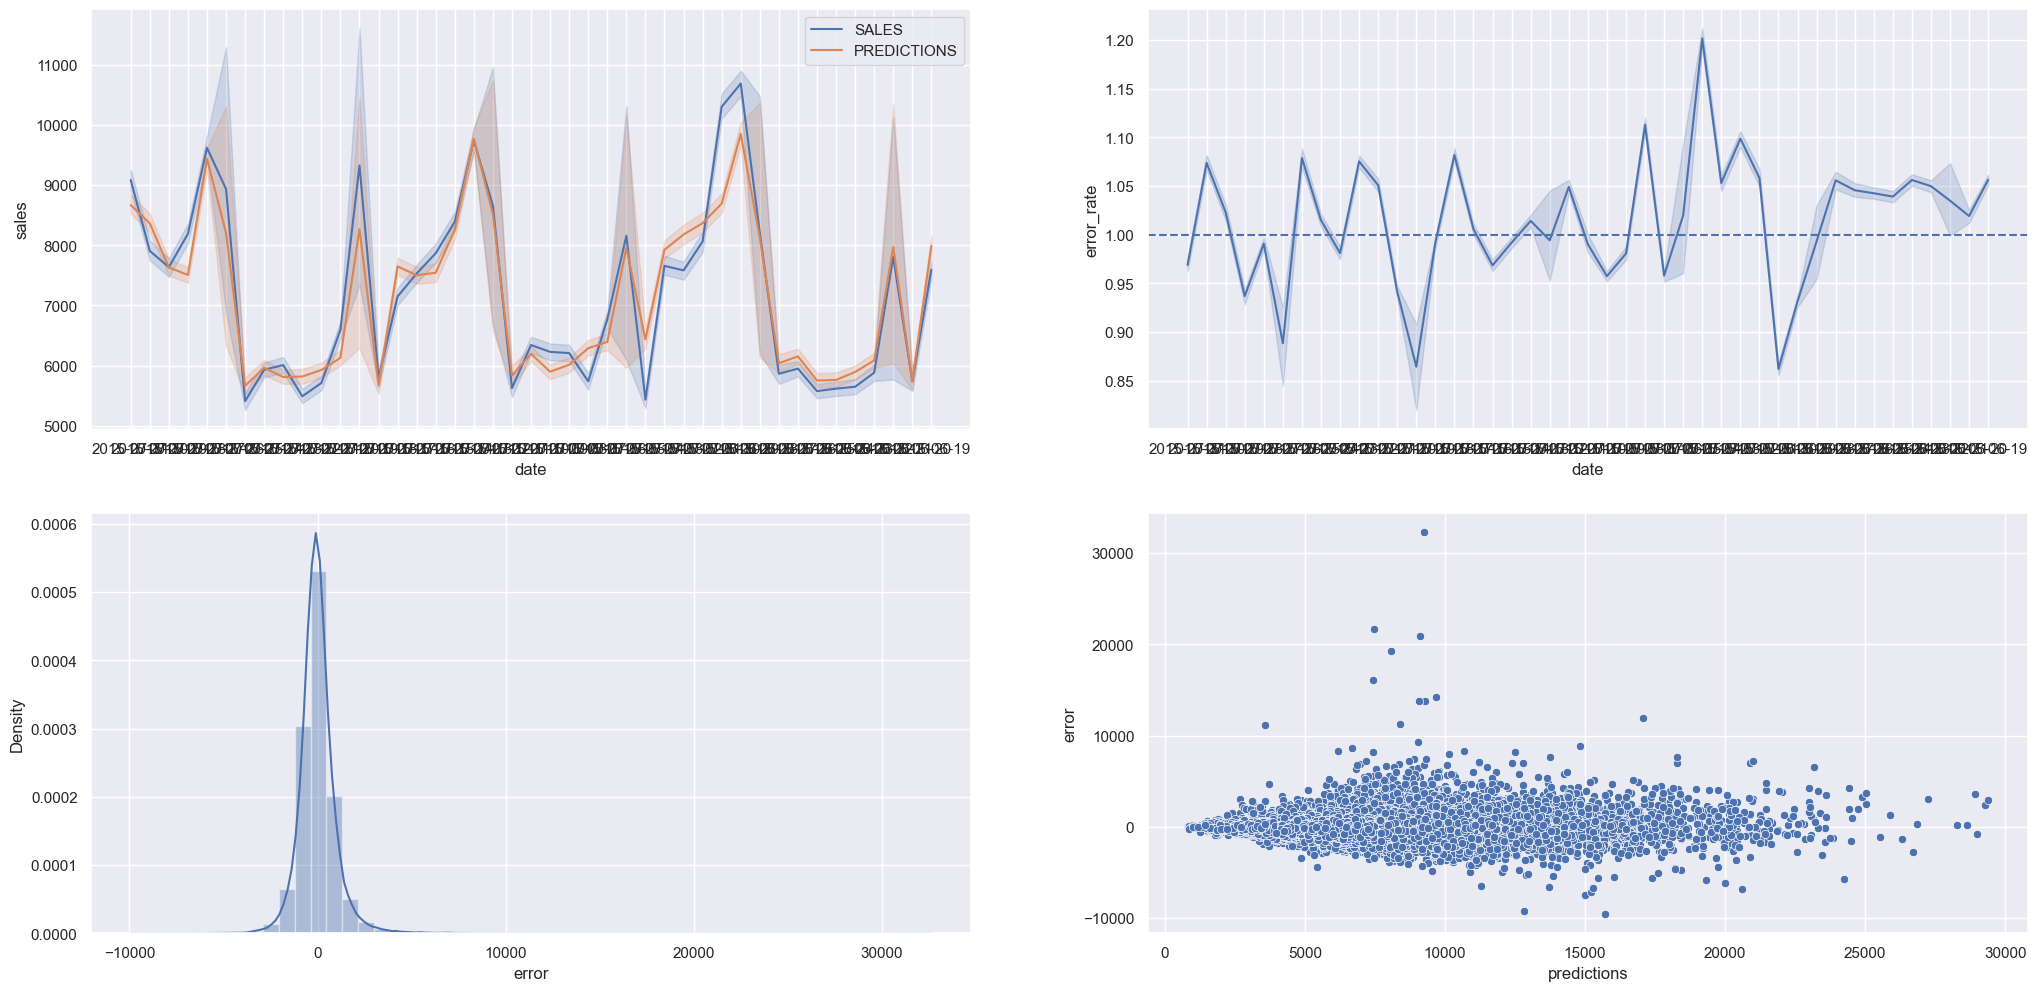

In [117]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')
plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )
plt.subplot( 2, 2, 4 )
sns.scatterplot(x =  df9['predictions'], y = df9['error'] )
